In [138]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import torch
import os
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from mftma.manifold_analysis_correlation import manifold_analysis_corr
from mftma.utils.make_manifold_data import make_manifold_data
from mftma.utils.activation_extractor import extractor
from mftma.utils.analyze_pytorch import analyze
import getpass
import mat73
import scipy
from datetime import datetime
from collections import defaultdict
import scipy.io as sio   
from scipy.io import loadmat
class CFAR100_fake_dataset(Dataset):
    def __init__(self, data_dir=data_dir):
        self.data_dir=data_dir
        self.dat , self.target=self.load_data()
        self.n_samples=self.dat.shape[0]
    def __len__(self):
        return self.n_samples
    def __getitem__(self, idx):
        #item=np.expand_dims(self.dat[idx],axis=0)
        item=self.dat[idx]
        targ=np.squeeze(self.target[idx])
        return (torch.tensor(item,dtype=torch.float), targ)
    def load_data(self):
        try:
            annot=loadmat(self.data_dir) 
            ops_struct=annot['ops_out']
            vals=ops_struct[0,0]
        except: 
            data_dict = mat73.loadmat(self.data_dir)
            vals=data_dict['ops_out']
        dat=vals['data']
        self.vals=vals
        self.adj=vals['Adjacency']
        dat_new=dat[:,range(3*32*32)]
        dat_new=np.reshape(dat_new,(-1,3,32,32))
        target=np.double(np.transpose(vals['class_id'])-1.0)
        return dat_new, target 
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [115]:
user=getpass.getuser()
print(user)
if user=='eghbalhosseini':
    save_dir='/Users/eghbalhosseini/MyData/neural_manifolds/VGG16_training_on_synthetic/'
    data_dir='/Users/eghbalhosseini/MyData/neural_manifolds/VGG16_training_on_synthetic/'
elif user=='ehoseini':
    save_dir='/om/user/ehoseini/MyData/neural_manifolds/VGG16_training_on_synthetic/'
    data_dir='/om/user/ehoseini/MyData/neural_manifolds/'

#data_file='synthtree_nobj_50000_nclass_50_nfeat_3072_norm_1.mat'

eghbalhosseini


# 1. Partition_dataset

In [ ]:
# load dataset 
data_file='synthpartition_nobj_50000_nclass_50_nfeat_3072_norm_1.mat'
train_dataset=CFAR100_fake_dataset(data_dir=os.path.join(data_dir,data_file))
# extract samples 
sampled_classes = 50
examples_per_class = 50
data = make_manifold_data(train_dataset, sampled_classes, examples_per_class,max_class=50, seed=0)
data = [d.to(device) for d in data]

## load model and extract activations 

In [129]:
model_save_path=save_dir+'VGG16_synthdata_'+train_dataset.vals.structure+'_nclass_'+str(int(train_dataset.vals.n_class))+'_n_exm_'+str(int(train_dataset.vals.exm_per_class))
model = models.vgg16(num_classes=50)
model.load_state_dict(torch.load(model_save_path,map_location=device))
model = model.to(device)
model = model.eval()
activations = extractor(model, data, layer_types=['Conv2d', 'Linear'])
list(activations.keys())

In [136]:
for layer, data, in activations.items():
    X = [d.reshape(d.shape[0], -1).T for d in data]
    # Get the number of features in the flattened data
    N = X[0].shape[0]
    # If N is greater than 5000, do the random projection to 5000 features
    if N > 5000:
        print("Projecting {}".format(layer))
        M = np.random.randn(5000, N)
        M /= np.sqrt(np.sum(M*M, axis=1, keepdims=True))
        X = [np.matmul(M, d) for d in X]
    activations[layer] = X

Projecting layer_1_Conv2d
Projecting layer_3_Conv2d
Projecting layer_6_Conv2d
Projecting layer_8_Conv2d
Projecting layer_11_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d


In [140]:
capacities = []
radii = []
dimensions = []
correlations = []

for k, X, in activations.items():
    # Analyze each layer's activations
    a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)
    
    # Compute the mean values
    a = 1/np.mean(1/a)
    r = np.mean(r)
    d = np.mean(d)
    print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))
    
    # Store for later
    capacities.append(a)
    radii.append(r)
    dimensions.append(d)
    correlations.append(r0)

layer_0_Input capacity: 0.175257, radius 0.769675, dimension 14.315628, correlation 0.026164
layer_1_Conv2d capacity: 0.174535, radius 0.776266, dimension 14.207200, correlation 0.042223
layer_3_Conv2d capacity: 0.166047, radius 0.790756, dimension 14.636377, correlation 0.050835
layer_6_Conv2d capacity: 0.156246, radius 0.819466, dimension 15.112569, correlation 0.065404
layer_8_Conv2d capacity: 0.144558, radius 0.838994, dimension 15.871647, correlation 0.066072
layer_11_Conv2d capacity: 0.115552, radius 1.000013, dimension 17.384773, correlation 0.085342
layer_13_Conv2d capacity: 0.122325, radius 2.993401, dimension 16.574724, correlation 0.092722
layer_15_Conv2d capacity: 0.116417, radius 4.031027, dimension 17.236520, correlation 0.093521
layer_18_Conv2d capacity: 0.129782, radius 0.894331, dimension 15.975922, correlation 0.113776
layer_20_Conv2d capacity: 0.150952, radius 0.876941, dimension 13.878998, correlation 0.116801
layer_22_Conv2d capacity: 0.241093, radius 0.758937, dim

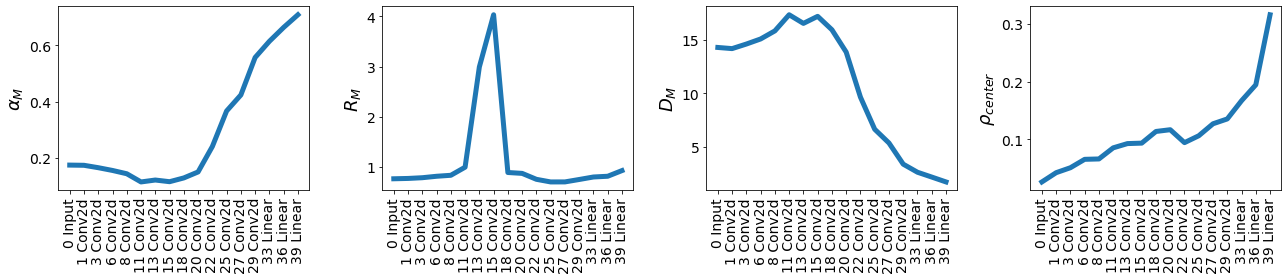

In [141]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
axes[1].set_ylabel(r'$R_M$', fontsize=18)
axes[2].set_ylabel(r'$D_M$', fontsize=18)
axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

names = list(activations.keys())
names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

# 2. Tree dataset

In [143]:
# load dataset 
data_file='synthtree_nobj_50000_nclass_50_nfeat_3072_norm_1.mat'
train_dataset=CFAR100_fake_dataset(data_dir=os.path.join(data_dir,data_file))
# extract samples 
sampled_classes = 50
examples_per_class = 50
data = make_manifold_data(train_dataset, sampled_classes, examples_per_class,max_class=50, seed=0)
data = [d.to(device) for d in data]

<HDF5 dataset "data": shape (100124,), type "<f8"> is not a matlab type
<HDF5 dataset "ir": shape (100124,), type "<u8"> is not a matlab type
<HDF5 dataset "jc": shape (50064,), type "<u8"> is not a matlab type
data type not supported: graph, uint32
data type not supported: graph, uint32


In [146]:
model_save_path=save_dir+'VGG16_synthdata_'+train_dataset.vals.structure+'_nclass_'+str(int(train_dataset.vals.n_class))+'_n_exm_'+str(int(train_dataset.vals.exm_per_class))
model = models.vgg16(num_classes=50)
model.load_state_dict(torch.load(model_save_path,map_location=device))
model = model.to(device)
model = model.eval()
activations = extractor(model, data, layer_types=['Conv2d', 'Linear'])
list(activations.keys())

['layer_0_Input',
 'layer_1_Conv2d',
 'layer_3_Conv2d',
 'layer_6_Conv2d',
 'layer_8_Conv2d',
 'layer_11_Conv2d',
 'layer_13_Conv2d',
 'layer_15_Conv2d',
 'layer_18_Conv2d',
 'layer_20_Conv2d',
 'layer_22_Conv2d',
 'layer_25_Conv2d',
 'layer_27_Conv2d',
 'layer_29_Conv2d',
 'layer_33_Linear',
 'layer_36_Linear',
 'layer_39_Linear']

In [147]:
for layer, data, in activations.items():
    X = [d.reshape(d.shape[0], -1).T for d in data]
    # Get the number of features in the flattened data
    N = X[0].shape[0]
    # If N is greater than 5000, do the random projection to 5000 features
    if N > 5000:
        print("Projecting {}".format(layer))
        M = np.random.randn(5000, N)
        M /= np.sqrt(np.sum(M*M, axis=1, keepdims=True))
        X = [np.matmul(M, d) for d in X]
    activations[layer] = X

Projecting layer_1_Conv2d
Projecting layer_3_Conv2d
Projecting layer_6_Conv2d
Projecting layer_8_Conv2d
Projecting layer_11_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d


In [148]:
capacities = []
radii = []
dimensions = []
correlations = []

for k, X, in activations.items():
    # Analyze each layer's activations
    a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)
    
    # Compute the mean values
    a = 1/np.mean(1/a)
    r = np.mean(r)
    d = np.mean(d)
    print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))
    
    # Store for later
    capacities.append(a)
    radii.append(r)
    dimensions.append(d)
    correlations.append(r0)

layer_0_Input capacity: 0.136940, radius 0.835399, dimension 16.926299, correlation 0.040407
layer_1_Conv2d capacity: 0.131887, radius 0.848052, dimension 17.275660, correlation 0.043651
layer_3_Conv2d capacity: 0.120592, radius 0.877318, dimension 18.391218, correlation 0.045511
layer_6_Conv2d capacity: 0.118855, radius 0.887083, dimension 18.407682, correlation 0.058878
layer_8_Conv2d capacity: 0.111012, radius 0.913044, dimension 19.191258, correlation 0.068854
layer_11_Conv2d capacity: 0.110967, radius 0.922494, dimension 18.724763, correlation 0.111722
layer_13_Conv2d capacity: 0.110035, radius 0.936036, dimension 18.680990, correlation 0.127688
layer_15_Conv2d capacity: 0.117176, radius 0.922105, dimension 17.644956, correlation 0.141490
layer_18_Conv2d capacity: 0.141717, radius 0.884710, dimension 15.101750, correlation 0.151584
layer_20_Conv2d capacity: 0.183469, radius 0.829944, dimension 12.265135, correlation 0.127269
layer_22_Conv2d capacity: 0.273679, radius 0.768492, dim

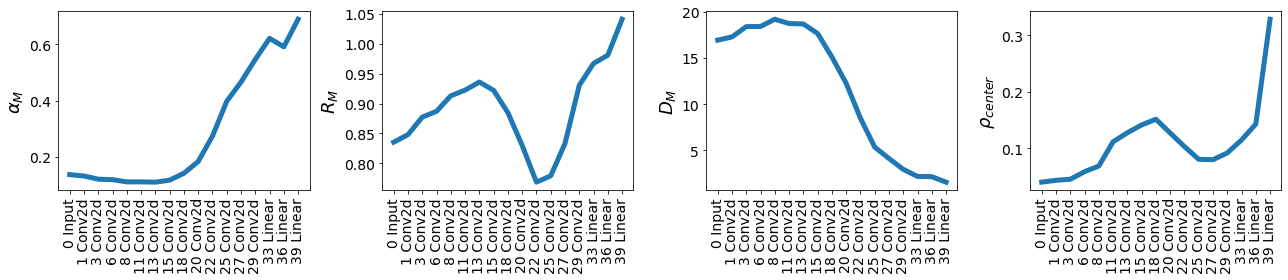

In [149]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
axes[1].set_ylabel(r'$R_M$', fontsize=18)
axes[2].set_ylabel(r'$D_M$', fontsize=18)
axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

names = list(activations.keys())
names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()